In [15]:
import numpy as np
import random
from survivors import metrics as metr
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [32]:
f"({123})|({456})"

'(123)|(456)'

In [36]:
class Scheme(object):
    def __init__(self, rule, times, cens, feat_means):
        self.rule = rule
        self.times = times
        self.cens = cens
        self.feat_means = feat_means
        self.shape = times.shape[0]
        self.kmf = metr.get_survival_func(self.cens, self.times)
        
    def join(self, sch):
        self.rule = f"({self.rule})|({sch.rule})"
        self.times = np.hstack([self.times, sch.times])
        self.cens = np.hstack([self.cens, sch.cens])
        self.feat_means = (self.feat_means + sch.feat_means)/2
        return self
    
    def copy(self):
        return Scheme(self.rule, self.times, self.cens, self.feat_means)
        
    def get_str_rules(self):
        return self.rule
        
    def get_description(self):
        descr = "\nКОЛ-ВО:" + str(self.shape) + ' '
        descr += f"ВЕРОЯТНОСТЬ СОБЫТИЯ:{round(np.mean(self.cens), 5)} "
        descr += "\n" + self.get_str_rules()
        return descr
    
    def get_subschemes(self, min_size=5, top=3):
        ret = {self.get_str_rules(): self.copy()}
        return ret
    
    def plot_sf(self, ax):
        return self.kmf.plot_survival_function(ax=ax, censor_styles = {"marker":'o', "ms":6}, ci_show = False)

class FilledSchemeStrategy(object):
    def __init__(self, schemes_list):
        self.schemes_dict = {sch.get_str_rules(): sch for sch in schemes_list}
    
    def join(self, fss):
        for k, v in fss.schemes_dict.items():
            if k in self.schemes_dict.keys():
                self.schemes_dict[k].join(v)
            else:
                self.schemes_dict[k] = v
    
    def join_nearest_leaves(self, sign_thres=0.05, diff_func=random.random):
        def delete_k_from_dict(d, del_k):
            d_ = dict()
            for k in d.keys():
                if not(del_k in k.split("#")):
                    d_[k] = d[k]
            return d_
            
        base = self.schemes_dict
        diff_dict = dict()
        for i1, l1 in enumerate(base.keys()):
            for i2, l2 in enumerate(base.keys()):
                if i2 > i1:
                    diff_dict[l1+'#'+l2] = diff_func()
                    #scrit.logrank_fast(base[l1].times, base[l2].times, base[l1].cens, base[l2].cens)
        while len(base) > 1:
            max_pair_key, max_p_val = max(diff_dict.items(), key=lambda x: x[1])
            print('Максимальное P-value:', max_p_val)
            if max_p_val < sign_thres:
                break
            f_l, s_l = max_pair_key.split('#')
            new_sch = base[f_l].copy()
            new_sch.join(base[s_l])
            new_sch_name = new_sch.get_str_rules()
            for k in [f_l, s_l]:
                diff_dict = delete_k_from_dict(diff_dict, k)
                del base[k]
            for k in base.keys():
                diff_dict[new_sch_name+'#'+k] = diff_func()
            base[new_sch_name] = new_sch
            print('Цепочки схем:', f_l, s_l)
            print('Заменяются на:', new_sch_name)
        self.schemes_dict = base
        
    def visualize(self, output_dir=None):
        if output_dir is None:
            plt.ioff()
        ind = 0
        legends = []
        fig, ax = plt.subplots(figsize=(7, 5))
        for k, v in self.schemes_dict.items():
            for k_sch, sch in v.get_subschemes().items():
                ind += 1
                descr = sch.get_description()       
                ax = sch.plot_sf(ax)
                legends.append(descr)
        if ind > 0:
            if output_dir is None:
                plt.show()
            else:
                plt.savefig(output_dir + "all_figure.png")
            legend = ax.legend(legends, bbox_to_anchor = (0,-0.1), loc = "upper left", ncol = 1, prop = {'size':10})
            
            fig_leg  = legend.figure
            fig_leg.canvas.draw()
            bbox  = legend.get_window_extent().transformed(fig_leg.dpi_scale_trans.inverted())
            if output_dir is None:
                fig_leg.show()
            else:
                fig_leg.savefig(output_dir + "all_legend.png", dpi="figure", bbox_inches=bbox)
        else:
            raise ValueError("Не выделены значимые схемы лечения")

In [39]:
a = Scheme(rule="(a > 0.5) & (b <= 0.5)", 
           times=np.array([1, 2, 3, 4, 5]), 
           cens=np.array([1, 0, 1, 0, 1]), 
           feat_means = np.array([1, 10, 100, 1000]))
b = Scheme(rule="(a > 0.5) & (b > 0.5)", 
           times=np.array([6, 7, 8, 9, 10]), 
           cens=np.array([1, 1, 1, 1, 1]), 
           feat_means = np.array([10, 10, 10, 10]))
c = Scheme(rule="(a <= 0.5) & (c <= 1000)", 
           times=np.array([11, 12, 13, 14, 15]), 
           cens=np.array([1, 1, 1, 1, 1]), 
           feat_means = np.array([1, 1, 1, 1]))
d = Scheme(rule="(a <= 0.5) & (c > 1000)", 
           times=np.array([16, 17, 18, 19, 20]), 
           cens=np.array([0, 1, 0, 0, 1]), 
           feat_means = np.array([100, 100, 100, 100]))

fss1 = FilledSchemeStrategy([a, b])
fss2 = FilledSchemeStrategy([c, d])
fss1.join(fss2)
fss1.join_nearest_leaves(sign_thres=0.5)

Максимальное P-value: 0.8800732531952435
Цепочки схем: (a <= 0.5) & (c <= 1000) (a <= 0.5) & (c > 1000)
Заменяются на: ((a <= 0.5) & (c <= 1000))|((a <= 0.5) & (c > 1000))
Максимальное P-value: 0.6178997604289962
Цепочки схем: ((a <= 0.5) & (c <= 1000))|((a <= 0.5) & (c > 1000)) (a > 0.5) & (b > 0.5)
Заменяются на: (((a <= 0.5) & (c <= 1000))|((a <= 0.5) & (c > 1000)))|((a > 0.5) & (b > 0.5))
Максимальное P-value: 0.38439299353676504


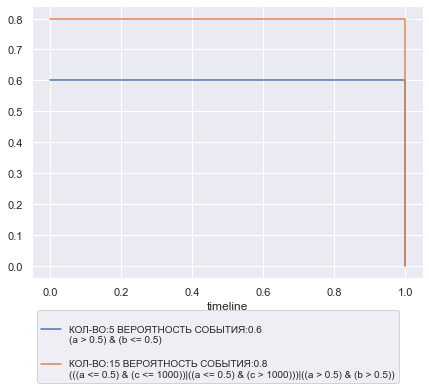

In [40]:
fss1.visualize(os.getcwd() +'\\')